<a href="https://colab.research.google.com/github/pan-emily/protein-clip/blob/main/MLM_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False

set_seed()

In [2]:
from pathlib import Path
import requests

peptide_url = 'http://bioinfo.dcc.ufmg.br/propedia/public/download/peptide.fasta'
receptor_url = 'http://bioinfo.dcc.ufmg.br/propedia/public/download/receptor.fasta'
peptide_data = requests.get(peptide_url).text
receptor_data = requests.get(receptor_url).text
with open('peptide.fasta', 'w') as f:
  f.write(peptide_data)
with open('receptor.fasta', 'w') as f:
  f.write(receptor_data)

peptides, receptors = [], []
with open('receptor.fasta', 'r') as f:
    for line in f.readlines():
        if not line.startswith('>'):
            receptors.append(line.replace('\n', ''))

with open('peptide.fasta', 'r') as f:
    for line in f.readlines():
        if not line.startswith('>'):
            peptides.append(line.replace('\n', ''))
assert len(peptides) == len(receptors)

In [3]:
!wget https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz
!tar xvzf mmseqs-linux-avx2.tar.gz
!cp mmseqs/bin/mmseqs /usr/bin/
!pip install biopython

!mmseqs createdb receptor.fasta receptorDB
!mmseqs cluster receptorDB receptorDB_clu tmp --min-seq-id 0.5
!mmseqs createtsv receptorDB receptorDB receptorDB_clu receptorDB_clu.tsv
!pip install transformers

--2023-11-03 04:16:49--  https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz
Resolving mmseqs.com (mmseqs.com)... 147.46.145.74
Connecting to mmseqs.com (mmseqs.com)|147.46.145.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45102888 (43M) [application/octet-stream]
Saving to: ‘mmseqs-linux-avx2.tar.gz.3’

mmseqs-linux-avx2.t 100%[===================>]  43.01M  7.18MB/s    in 5.9s    

2023-11-03 04:16:56 (7.27 MB/s) - ‘mmseqs-linux-avx2.tar.gz.3’ saved [45102888/45102888]

mmseqs/
mmseqs/bin/
mmseqs/bin/mmseqs
mmseqs/examples/
mmseqs/examples/DB.fasta
mmseqs/examples/QUERY.fasta
mmseqs/util/
mmseqs/util/bash-completion.sh
mmseqs/README.md
mmseqs/userguide.pdf
mmseqs/matrices/
mmseqs/matrices/blosum75.out
mmseqs/matrices/PAM20.out
mmseqs/matrices/blosum65.out
mmseqs/matrices/blosum45.out
mmseqs/matrices/blosum90.out
mmseqs/matrices/blosum50.out
mmseqs/matrices/blosum85.out
mmseqs/matrices/blosum30.out
mmseqs/matrices/PAM60.out
mmseqs/matrices/PAM30.out
mmseq

In [4]:
from Bio import SeqIO
id_to_seq = {}
receptors_parsed = list(SeqIO.parse('receptor.fasta', 'fasta'))
for receptor_parsed in receptors_parsed:
    id_to_seq[receptor_parsed.id] = str(receptor_parsed.seq)
receptor_to_peptide = dict(zip(receptors, peptides))

with open('receptorDB_clu.tsv', 'r') as f:
    clusters = {}
    for line in f:
        cluster_id, receptor_id = line.strip().split("\t")
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        receptor_sequence = id_to_seq[receptor_id]
        peptide_sequence = receptor_to_peptide[receptor_sequence]
        clusters[cluster_id].append((peptide_sequence, receptor_sequence))

cluster_ids = list(clusters.keys())
random.shuffle(cluster_ids)
num_train = int(0.7 * len(cluster_ids))
num_val = int(0.15 * len(cluster_ids))
train_clusters = cluster_ids[:num_train]
val_clusters = cluster_ids[num_train:num_train+num_val]
test_clusters = cluster_ids[num_train+num_val:]

In [5]:
from torch.utils.data import Dataset, DataLoader

def mask_sequence(sequence, mask_prob, mask_token='.'):
    chars = list(sequence)
    mask_indices = np.random.rand(len(chars)) < mask_prob
    for i, mask in enumerate(mask_indices):
        if mask:
            chars[i] = mask_token
    return ''.join(chars)

class PeptideReceptorDataset(Dataset):
    def __init__(self, clusters, cluster_ids, mask_prob):
        self.clusters = clusters
        self.cluster_ids = cluster_ids
        self.mask_prob = mask_prob
    def __len__(self):
        return len(self.cluster_ids)

    def __getitem__(self, idx):
        curr_cluster = self.clusters[self.cluster_ids[idx]]
        curr_pair = random.choice(curr_cluster)
        peptide_sequence = curr_pair[0]
        receptor_sequence = curr_pair[1]
        masked_peptide_sequence = mask_sequence(peptide_sequence, self.mask_prob)
        masked_receptor_sequence = mask_sequence(receptor_sequence, self.mask_prob)
        return peptide_sequence, receptor_sequence, masked_peptide_sequence, masked_receptor_sequence

In [6]:
from transformers import EsmModel, EsmTokenizer
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

def get_diff(unmasked_ids, masked_ids):
    # Count the number of positions where the token IDs differ
    num_differences = torch.sum(unmasked_ids != masked_ids).item()
    # Calculate the total number of token positions
    total_positions = unmasked_ids.numel()
    # Calculate the percentage of differences
    p_diff = (num_differences / total_positions)
    return p_diff

# Function to compare token ids of masked and unmasked sequences
def compare_tokens(batch_sequences, batch_masked_sequences, mask_prob, debug=False):
    # Tokenize the sequences
    tokens_unmasked = tokenizer(batch_sequences, return_tensors='pt', padding=True, truncation=True)
    tokens_masked = tokenizer(batch_masked_sequences, return_tensors='pt', padding=True, truncation=True)

    # Compare the token ids
    unmasked_ids = tokens_unmasked['input_ids']
    masked_ids = tokens_masked['input_ids']

    # Print out or return the comparison
    if debug:
      print("Unmasked Token IDs:", unmasked_ids)
      print("Masked Token IDs:", masked_ids)

    return get_diff(tokens_unmasked['input_ids'], tokens_masked['input_ids'])

In [ ]:
token_diff_per_mask_peptides = []
token_diff_per_mask_receptors = []
batch_size = 32
for mask_prob in [0.05, 0.1, 0.15, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:

  train_dataset = PeptideReceptorDataset(clusters, train_clusters, mask_prob)
  val_dataset = PeptideReceptorDataset(clusters, val_clusters, mask_prob)
  test_dataset = PeptideReceptorDataset(clusters, test_clusters, mask_prob)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

  token_diffs_peptides = []
  token_diffs_receptors = []

  for batch in train_loader:
      batch_peptides, batch_receptors, batch_masked_peptides, batch_masked_receptors = batch  # Assuming your DataLoader yields tuples of (peptide, receptor, masked_peptide)
      diff_peptides = compare_tokens(batch_peptides, batch_masked_peptides, mask_prob)
      diff_receptors = compare_tokens(batch_receptors, batch_masked_receptors, mask_prob)
      token_diffs_peptides.append(diff_peptides)
      token_diffs_receptors.append(diff_receptors)

  # counts, bins = np.histogram(token_diffs)
  # plt.stairs(counts, bins, fill=True)
  # plt.title(f'Difference Between Masked Receptor Token vs Original Token (P), Masked={mask_prob}')
  # plt.show()

  token_diff_per_mask_peptides.append(token_diffs_peptides)
  token_diff_per_mask_receptors.append(token_diffs_receptors)

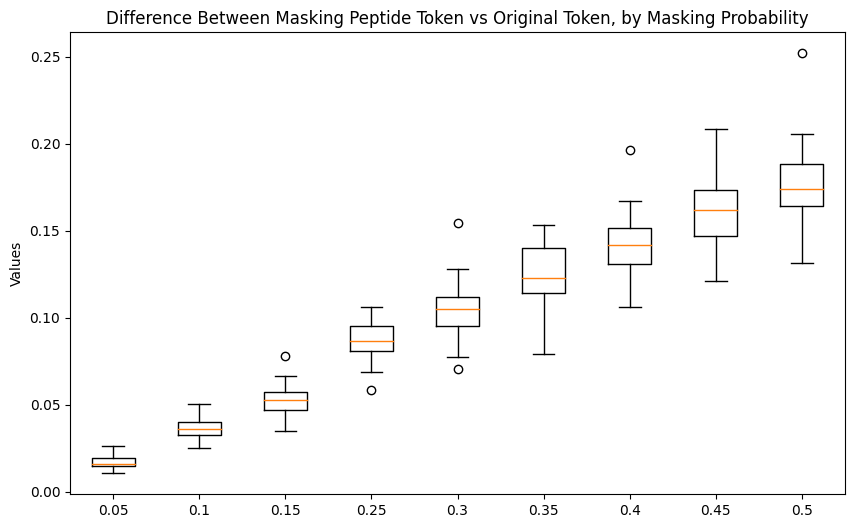

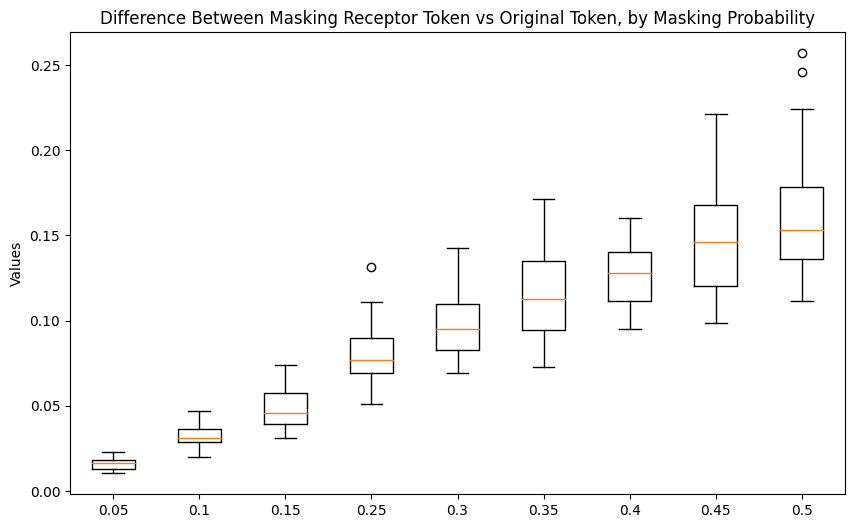

In [11]:
fig = plt.figure(1, figsize=(10, 6))

ax = fig.add_subplot(111)
bp = ax.boxplot(token_diff_per_mask_peptides)

ax.set_xticklabels([0.05, 0.1, 0.15, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
ax.set_ylabel('Values')
ax.set_title('Difference Between Masking Peptide Token vs Original Token, by Masking Probability')
plt.show()

fig = plt.figure(1, figsize=(10, 6))

ax = fig.add_subplot(111)
bp = ax.boxplot(token_diff_per_mask_receptors)

ax.set_xticklabels([0.05, 0.1, 0.15, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
ax.set_ylabel('Values')
ax.set_title('Difference Between Masking Receptor Token vs Original Token, by Masking Probability')
plt.show()